In [18]:
import numpy as np
import time
import math
import modules as md
import nbodysolver as nbs
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


#------------------------------------------------------------------------------------------
#Units and conversions:
#------------------------------------------------------------------------------------------
#code units: Rsun, Msun, G=1, ...
c_SI       = 299792458.0        #m/s
M_sun_SI   = 1.989*(10.**30.)   #kg
R_sun_SI   = 695800000.         #m
R_bull_SI = 1000 #m 
AU_SI      = 149597871000.      #m 
G_new_SI   = 6.67*(10.**(-11.)) #m**3 kg**(-1) s**(-2)
AU_U       = AU_SI/R_sun_SI                             #from dist AU to code units (U)
kmsec_U    = 1000./np.sqrt(G_new_SI*M_sun_SI/R_bull_SI)  #from vel km/sec to code units (U)
time_U     = 1/np.sqrt(G_new_SI*M_sun_SI/R_bull_SI**3) #from CU to second np.sqrt((R_bull_SI)/(G_new_SI*M_sun_SI)) #from code units(U) to time sec
#Rsch_1Msun_unitRsun = ((2.*G_new_SI*(1.*M_sun_SI))/(c_SI**2.))/R_sun_SI
c_CU = c_SI/1000*kmsec_U

## Newtonian 

In [19]:
#Acceleration

def acc(r,m): #r position, m mass
    a = np.zeros((len(r),3)) #Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rrel = r[i]-r[j]
                rn = (rrel**2).sum()**(1./2) 
                a[i] += -(rrel)*m[j]/(rn**3.0) #Acceleration at each time step 
    return a # return acceleration


def Jerk(r,v,m): #position, velocity, mass
    Je = np.zeros((len(r),3)) #Define the Jerk
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = r[i]-r[j]
                vrel = v[i]-v[j]
                rn = (rrel**2).sum()**(1./2) # dot product
                vn = (vrel**2).sum()**(1./2)
                rvd = ((rrel)*(vrel)).sum()
                Je[i] += - m[j]*((vrel)/rn**3.0 - 3.*(rvd*rrel/(rn**5.0))) 
    return Je;



# Tides 

In [20]:
def acctide(r,m,ne): #r position, m mass, s spin, m mass of the star and the value of ne
    a = np.zeros((len(r),3)) #Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rvec = r[i,:]-r[j,:]
                ra = ((rvec**2).sum())**(1./2) #dot product
                runi = rvec/ra
                a[i,:] += -(9.)*ne[i]*((m[j]**2)/m[i])*(runi)/(ra**7.0) #Acceleration at each time step 
    return a # return acceleration

#V2
#def acctide(r,m,ne): #r position, m mass, s spin, m mass of the star and the value of ne
#    a = np.zeros((len(r),3)) #Create acceleration vector
#    
#    for i in range(len(r)): #Range is size of timesteps or position steps
#        for j in range(len(r)): #For each particle                                                 
#            if (i != j):
#                rrel = r[i]-r[j]
#                rn = ((rrel**2).sum())**(1./2) #norm   
#                a[i] += -(9.)*ne[i]*((m[j]**2)/m[i])*(rrel)/(rn**8.0) #Acceleration at each time step 
#    return a # return acceleration

def Jerktide(r,v,m, ne): #r position, v velocity, m mass, m mass of the star, ne
    Je = np.zeros((len(r),3)) #Define the Jerk
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = (r[i]-r[j])
                vrel = (v[i]-v[j])
                rn = ((rrel**2).sum())**(1./2) # dot product
                Je[i,:] += - (9.0)*ne[i]*((m[j]**2)/m[i])*( vrel/rn**8.0 - 8.*((vrel*rrel).sum())*(rrel)/(rn**10.0) ) 
                #ra = (((r[i,:]-r[j,:])**2).sum())**(1./2) # dot product
                #Je[i,:] += - (9.0)*ne[i]*((m[j]**2)/m[i])*( (v[i,:]-v[j,:])/ra**8.0 - 8.*(((v[i,:]-v[j,:])*(r[i,:]-r[j,:])).sum())*(r[i,:]-r[j,:])/(ra**10.0) ) 
    return Je;

#def Jerktide(r,v,m,ne): #r position, v velocity, m mass, m mass of the star, ne
#    Je = np.zeros((len(r),3)) #Define the Jerk
#    for i in range(len(r)):
#        for j in range(len(r)):
#            if (i != j):
#                rrel = r[i]-r[j]
#                vrel = v[i]-v[j]
#                rn = ((rrel**2).sum())**(1./2) #norm 
#                Je[i] += - (9.0)*ne[i]*((m[j]**2)/m[i])*( vrel/rn**8.0 - 8.*((vrel*rrel).sum())*(rrel)/(rn**10.0) ) 
#    return Je;


####v2
def HermiteUpdatetidedt(dt, r, v, m, ns): # m mass of the star
    
    aN = acc(r, m) 
    aT = acctide(r, m, ns)
    a = aN + aT           # current acceleration
    aNdot = Jerk(r,v,m)
    aTdot = Jerktide(r, v, m, ns)
    adot = aNdot + aTdot # current jerks
    rp = r + dt*v + dt**2/2 * a + dt**3/6* adot   # predict
    vp = v + dt*a + dt**2/2 * adot

    aNp = acc(rp, m)
    aTp = acctide(rp, m, ns)
    ap = aNp + aTp         # predicted acceleration

    aNdotp = Jerk(rp, vp, m)
    aTdotp = Jerktide(rp, vp, m, ns)
    adotp = aNdotp + aTdotp  # predicted jerks 
    
    #compute some other things to find the best value for the timestep
    #Newtonian
    #a2 = (1./dt**2)*(-6*(a-ap)-dt*(4*adot + 2*adotp))
    #a3 = (1./dt**3)*(-12*(a-ap)-6*dt*(adot + adotp))
    #ac = a + adot*dt + (1./2)*(dt**2)*a2 + (1./6)*(dt**2)*a3 
    
    #Tides
    #a2 = (1./dt**2)*(-6*(aT-aTp)-dt*(4*aTdot + 2*aTdotp))
    #a3 = (1./dt**3)*(-12*(aT-aTp)-6*dt*(aTdot + aTdotp))
    #ac = aT + aTdot*dt + (1./2)*(dt**2)*a2 + (1./6)*(dt**2)*a3
    #adotpn = ((aTdotp**2).sum())**(1./2)

    
    #a2c = a2 + dt*a3    
    #acn = ((ac**2).sum())**(1./2) #dot product
    #a2cn = ((a2c**2).sum())**(1./2)
    #a3n = ((a3**2).sum())**(1./2)
    #dtp = (accu*(acn*a2cn + adotpn**2)/(adotpn*a3n + a2cn**2))**(1./2)

    dtp = dt
    
    vp = v + dt/2*(a+ap) - dt**2/12*(adotp-adot)  # correct
    rp = r + dt/2*(v + vp) - dt**2/10 * (ap-a)
 
    return rp,vp,ap,adotp,aNp,aNdotp,dtp

def Hermite4thtidedt(pri,sec, bina, nsteps, Dt):
    
    N=2
    m = np.ones(N)#/N #Remove the N if not necessary
    m[0]=pri.mass
    m[1]=sec.mass
    
    r_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    v_res = np.zeros((2,3,nsteps))

    aN_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    adotN_res = np.zeros((2,3,nsteps))

    a_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    adot_res = np.zeros((2,3,nsteps))

    
    time = np.zeros(nsteps)
    r_res[:,:,0] = bina.r.copy()
    v_res[:,:,0] = bina.v.copy()
    ntidev = np.array([pri.ntide, sec.ntide])
    
    dtp = np.zeros(nsteps)
    dtp[0] = Dt
    
    for i in range(1,nsteps):
        (r_res[:,:,i],v_res[:,:,i],a_res[:,:,i],adot_res[:,:,i],aN_res[:,:,i],adotN_res[:,:,i], dtp[i]) = HermiteUpdatetidedt(Dt, r_res[:,:,i-1], v_res[:,:,i-1], m, ntidev)
        time[i] = time[i-1] + Dt#+ dtp[i-1] #+ Dt #
        if time[i] >= timelimit:
            break
            
    r_res = r_res[:,:,:i]
    v_res = v_res[:,:,:i]
    a_res = a_res[:,:,:i]
    adot_res = adot_res[:,:,:i]
    aN_res = aN_res[:,:,:i]
    adotN_res = adotN_res[:,:,:i]
    dtp = dtp[:i]
    time = time[:i]
        
    return r_res, v_res, a_res, adot_res, aN_res, adotN_res, dtp, time






## Circular Orbit 

In [21]:
#Define ns
ns = md.Particle("NS",1.2,8.89,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius
#Define bh
bh3 = md.Particle("BH",5,0,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius


#Define binary
bh3ns10rt = md.Binary(bh3, ns, 4*ns.radi, 0)

rt = 2

bh3nsco = md.Binary(bh3, ns, rt*bh3ns10rt.tidalrsec, 0) ##primary, secondary, orbital distance (Rsun), eccentricity


#bh3nsco.orbd = rt*bh3nsco.tidalrsec

print(bh3nsco.orbd)
print(bh3nsco.tideeffsec)

print(ns.radi)
print(bh3nsco.tidalrsec)


28.610668763813496
0.027224338647948012
8.89
14.305334381906748


In [39]:
#accu = 0.001 # Set accuracy parameter 0.0000000001  works good, try add another 0
tl = 5*bh3nsco.periodct #Time of the simulation in [cpde units]
timelimit = tl #
dt = 0.001 # 0.0001 working better 
Nsteps = int(tl/dt)#Number of timesteps with the guessed timestep 


#Better accuracy
#accu = 0.00000000001 # Set accuracy parameter 0.0000000001  works good, try add another 0
#tl = 0.15*bh3nsrt.periodct #Time of the simulation in [cpde units]
#timelimit = tl #
#dt = 0.0005 # 0.0001 working better 
#Nsteps = int(tl/dt)#Number of timesteps with the guessed timestep 


In [40]:
rwtco,vwtco,aTco,adotTco,aNco,adotNco,dtpwtco,timewtco = Hermite4thtidedt(bh3,ns, bh3nsco, Nsteps, dt)

In [41]:
print(max(dtpwtco))
print(min(dtpwtco[1:]))

0.001
0.001


In [42]:
aTcoc = aTco + adotTco*dtpwtco#Acceleration corrected
aNcoc = aNco + adotNco*dtpwtco

aratioco = np.zeros_like(aNco[1].T)
for i in range(len(aNco[1].T)-1):
    aratioco[i+1][0] = (aTcoc[1].T[i+1][0])/(aNcoc[1].T[i+1][0])
    aratioco[i+1][1] = (aTcoc[1].T[i+1][1])/(aNcoc[1].T[i+1][1])
    #print(aratio[i][1])
    
#define relative position
relposTco = rwtco[1].T - rwtco[0].T 
#define relative velocity
relvelTco = vwtco[1].T - vwtco[0].T

normrelposTco = np.zeros([len(relposTco), 1]) 
normrelvelTco = np.zeros([len(relvelTco), 1]) 

for i in range(len(normrelposTco)):
    normrelposTco[i] = np.sqrt(relposTco[i][0]**2 + relposTco[i][1]**2 + relposTco[i][2]**2)
    normrelvelTco[i] = np.sqrt(relvelTco[i][0]**2 + relvelTco[i][1]**2 + relvelTco[i][2]**2)
    
print(len(normrelposTco.T[0]))
print(min(normrelposTco))
print(max(normrelposTco))

1930837
[27.25481599]
[28.61066876]


In [43]:
print(min(normrelposTco)/bh3nsco.tidalrsec)

[1.90522048]


In [44]:
n_exco = (normrelposTco.T[0]**5)*(1./9)*(1.*ns.mass/bh3.mass)*(aratioco.T[0] - 1) 
n_eyco = (normrelposTco.T[0]**5)*(1./9)*(1.*ns.mass/bh3.mass)*(aratioco.T[1] - 1)

No handles with labels found to put in legend.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


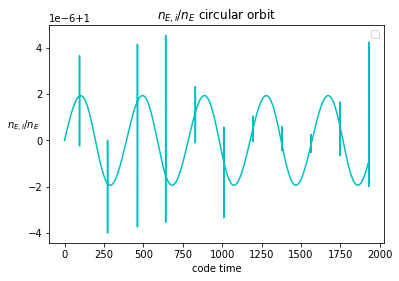

In [73]:
plt.plot(timewtco[1:], n_exco[1:]/ns.ntide, 'c-', alpha = 1)
#plt.plot(timearrayN.T[0][2:], n_ey[1:], 'b-', label = r'$n_{Ey}$', alpha = 0.5)
#plt.plot(timearrayT[1:], posydif, 'b-', label = r'$\Delta y$', alpha = 0.8)

#plt.plot(timeave, dynstave.T[1], 'b-', label = r'$star$', alpha = 0.8)
#plt.plot(time[1:], n_e.T[2], 'g-', label = r'$n_{ez}$', alpha = 0.8)
#plt.xlim(0,30)
#plt.ylim(0.0955,0.09555)
plt.xlabel('code time')
plt.ylabel(r'$n_{E,i}/n_E$',rotation=0)

plt.title(r'$n_{E,i} / n_E $ circular orbit')
plt.legend()
plt.savefig('ne-evolution-circular-0.001-4rs-5orbits.eps', bbox_inches='tight')#, dpi=300

plt.show()

In [64]:
print(min(n_exco[1:]))
print(max(n_exco))
print(ns.ntide)
print(min(n_exco[1:])/ns.ntide)
print(max(n_exco)/ns.ntide)

13917.600787033503
13917.720134792284
13917.65663191198
0.9999959874797926
1.0000045627566467


In [60]:
np.where(n_exco == 13917.754877605363)

(array([1196748]),)

In [61]:
n_exco[1196748]= 13917.65663191198

In [59]:
print(min(n_exco[1:]))
print(max(n_exco))
print(ns.ntide)

13917.600787033503
13917.754877605363
13917.65663191198


No handles with labels found to put in legend.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


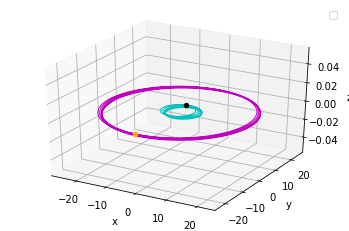

In [71]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(rwtco[0][0], rwtco[0][1], rwtco[0][2], 'c', linewidth=1)# Plot the BH orbit
ax.plot(rwtco[1][0], rwtco[1][1], rwtco[1][2], 'm', linewidth=1)# Plot the star orbit
ax.scatter3D(rwtco[0][0][-1], rwtco[0][1][-1], rwtco[0][2][-1], 'o', c='black') #s=100
ax.scatter3D(rwtco[1][0][-1], rwtco[1][1][-1], rwtco[1][2][-1], '0', c='orange') #s=10
ax.legend()
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#ax.set_xlim3d(-1,1)
#ax.set_ylim3d(-1,1)
#ax.set_xlim3d(min(min(posbh1x), min(posbh2x)), max(max(posbh1x), max(posbh2x)))
#ax.set_ylim3d(min(min(posbh1y), min(posbh2y)), max(max(posbh1y), max(posbh2y)))
#ax.set_zlim3d(min(min(posbh1z), min(posbh2z)), max(max(posbh1z), max(posbh2z)))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


plt.savefig('ne-circular2rt-5orbits.eps',bbox_inches='tight')#, dpi=300

plt.show()

# Parabolic Orbit 

In [4]:
#Define ns
ns = md.Particle("NS",1.2,8.89,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius
#Define bh
bh3 = md.Particle("BH",5,0,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius

#Define binary
nsns = md.Binary(ns, ns, ns.radi*10, 0) ##primary, secondary, orbital distance (Rsun), eccentricity 
bh3ns = md.Binary(ns, bh3, ns.radi*10, 0)

bh3nsrt = md.Binary(bh3, ns, 15*bh3ns.tidalrsec, 0)

#Define ns
ns = md.Particle("NS",1.2,8.89,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius
#Define bh
bh3 = md.Particle("BH",5,0,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius

bh3nsp = md.Binary(bh3, ns, 442, 0) #Orbital distance is changed

#15 tidal radius distance
bh3nsp.r[0] =np.array([24.26435111, 33.74222957, 0.])
bh3nsp.r[1] = np.array([-101.10146295, -140.5926232, 0.])
bh3nsp.v[0] = np.array([-0.04138964, -0.02121636, 0.])
bh3nsp.v[1] = np.array([0.17245682, 0.08840148, 0.])

#30 tidal radius distance
#bh3nsp.r[0] = np.array([68.20417117, 51.56082482, 0. ])
#bh3nsp.r[1] = np.array([-284.18404651, -214.83677007, 0.])

#bh3nsp.v[0] = np.array([-0.03074346, -0.01031287, 0.])
#bh3nsp.v[1] = np.array([0.12809776, 0.04297029, 0. ])

print(bh3nsrt.orbd)
print(bh3nsrt.tideeffsec)

print(ns.radi)
print(bh3ns.tidalrsec)

221.41674919713927
9.807200047995586e-07
8.89
14.761116613142619


In [35]:
accu = 0.0000000001 # Set accuracy parameter 0.0000000001  works good, try add another 0
tl = 0.18*bh3nsrt.periodct #Time of the simulation in [cpde units]
timelimit = tl #
dt = 0.0001 # 0.0001 working better 
Nsteps = int(tl/dt)#Number of timesteps with the guessed timestep 


#Better accuracy
#accu = 0.00000000001 # Set accuracy parameter 0.0000000001  works good, try add another 0
#tl = 0.15*bh3nsrt.periodct #Time of the simulation in [cpde units]
#timelimit = tl #
#dt = 0.0005 # 0.0001 working better 
#Nsteps = int(tl/dt)#Number of timesteps with the guessed timestep 


In [66]:
rwt,vwt,aT,adotT,aN,adotN,dtpwt,timewt = Hermite4thtidedt(bh3,ns, bh3nsp, Nsteps, dt)

KeyboardInterrupt: 

In [ ]:
print(max(dtpwt))
print(min(dtpwt[1:]))

In [ ]:
aTc = aT + adotT*dtpwt#Acceleration corrected
aNc = aN + adotN*dtpwt

aratio = np.zeros_like(aN[1].T)
for i in range(len(aN[1].T)-1):
    aratio[i+1][0] = (aTc[1].T[i+1][0])/(aNc[1].T[i+1][0])
    aratio[i+1][1] = (aTc[1].T[i+1][1])/(aNc[1].T[i+1][1])
    #print(aratio[i][1])
    
#define relative position
relposT = rwt[1].T - rwt[0].T 
#define relative velocity
relvelT = vwt[1].T - vwt[0].T

normrelposT = np.zeros([len(relposT), 1]) 
normrelvelT = np.zeros([len(relvelT), 1]) 

for i in range(len(normrelposT)):
    normrelposT[i] = np.sqrt(relposT[i][0]**2 + relposT[i][1]**2 + relposT[i][2]**2)
    normrelvelT[i] = np.sqrt(relvelT[i][0]**2 + relvelT[i][1]**2 + relvelT[i][2]**2)
    
print(len(normrelposT.T[0]))
print(min(normrelposT))
print(max(normrelposT))

In [ ]:
print(min(normrelposT))
print(bh3ns.tidalrsec)
print(min(normrelposT)/bh3ns.tidalrsec)

In [ ]:
print(max(normrelposT))
print(max(normrelposT)/bh3ns.tidalrsec)

In [ ]:
n_ex = (normrelposT.T[0]**5)*(1./9)*(1.*ns.mass/bh3.mass)*(aratio.T[0] - 1) 
n_ey = (normrelposT.T[0]**5)*(1./9)*(1.*ns.mass/bh3.mass)*(aratio.T[1] - 1)

In [ ]:
plt.plot(timewt[1:], n_ex[1:], 'm-', label = r'$n_{E}$', alpha = 1)
#plt.plot(timearrayN.T[0][2:], n_ey[1:], 'b-', label = r'$n_{Ey}$', alpha = 0.5)
#plt.plot(timearrayT[1:], posydif, 'b-', label = r'$\Delta y$', alpha = 0.8)

#plt.plot(timeave, dynstave.T[1], 'b-', label = r'$star$', alpha = 0.8)
#plt.plot(time[1:], n_e.T[2], 'g-', label = r'$n_{ez}$', alpha = 0.8)
#plt.xlim(0,30)
#plt.ylim(13917.5,13917.8)
plt.xlabel('code time')
plt.ylabel(r'$n_{E}$',rotation=0)

plt.title(r'$n_{E}$ evolution in parabolic orbit')
plt.legend()
#plt.savefig('time-vs-ne-parabolicrp3rt.eps', bbox_inches='tight')#, dpi=300

plt.show()

In [ ]:
print(min(n_ex[1:]))
print(max(n_ex))
print(ns.ntide)

No handles with labels found to put in legend.


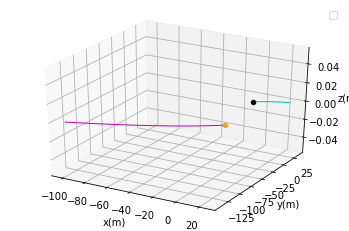

In [81]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(rwt[0][0], rwt[0][1], rwt[0][2], 'c', linewidth=1)# Plot the BH orbit
ax.plot(rwt[1][0], rwt[1][1], rwt[1][2], 'm', linewidth=1)# Plot the star orbit
ax.scatter3D(rwt[0][0][-1], rwt[0][1][-1], rwt[0][2][-1], 'o', c='black' ) #s=100
ax.scatter3D(rwt[1][0][-1], rwt[1][1][-1], rwt[1][2][-1], 'o', c='orange') #s=10
ax.legend()
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#ax.set_xlim3d(-1,1)
#ax.set_ylim3d(-1,1)
#ax.set_xlim3d(min(min(posbh1x), min(posbh2x)), max(max(posbh1x), max(posbh2x)))
#ax.set_ylim3d(min(min(posbh1y), min(posbh2y)), max(max(posbh1y), max(posbh2y)))
#ax.set_zlim3d(min(min(posbh1z), min(posbh2z)), max(max(posbh1z), max(posbh2z)))
ax.set_xlabel('x(m)')
ax.set_ylabel('y(m)')
ax.set_zlabel('z(m)')


#plt.savefig('ne-parabolicrp3rt.eps', bbox_inches='tight')#, dpi=300

plt.show()

In [74]:
bh3.radi
ns.radi

8.89